# Hull White model

Consider the generic HJM Framework where the instantaneous forward rate follows the dynamic:

$$ df(t,T) = \alpha(t, T) dt + \sigma(t, T) dW^{\mathbb{Q}}_t$$

Hull white model:

The model is defined as a particular case of the HJM with $\sigma(t. T) = \sigma e^{-\lambda (T-t)}$. 

Then:
$$\alpha(t, T) = \frac{\sigma^2}{\lambda} \left[ e^{-\lambda (T-t)} - e^{-2\lambda (T-t)} \right]$$

Thanks to the no-arb condition the short rate can be expressed as:

$$ dr_t = df(t,t) =  \lambda (\frac{1}{\lambda}\partial_t f(0,t) + f(0,t) + \frac{\sigma^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right) - r_t) dt + \sigma dW^{\mathbb{Q}}_t$$


and The price of a zero coupon bond is given as:

$$ B(t, T) = \mathbb{E}^{\mathbb{Q}}\left(e^{-\int_t^T r_s ds} | \mathcal{F}_t\right) $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from research.config import plots

plots.init(width=10)

%matplotlib inline


In [2]:
from scipy.optimize import minimize

In [3]:
from research.config import plots
from research.fixedincome.curves.parametrization import Svensson


In [4]:
# Source ECB data
beta_0 = 1.676684
beta_1 = -2.436684
beta_2 = 11.671905
beta_3 = -16.267864
tau_1 = 1.38377
tau_2 = 1.612824

We start by loading the the instantaneous forward rate downloaded from the ECB website, corresponding to AAA rated bond's spot rates as of 9th of February 2017, and that can be found in:
[ECB Europa website](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)

In [5]:
yc = pd.read_csv('ecb_yc.csv', header=0)
yc.head()

,T,IFR
0,0.25,-0.756633
1,0.50,-0.781512
2,0.75,-0.812951
3,1.00,-0.837306
4,2.00,-0.759330


In [6]:
svensson_curve = Svensson(beta_0, beta_1, beta_2, beta_3, tau_1, tau_2)

We plot the term structure

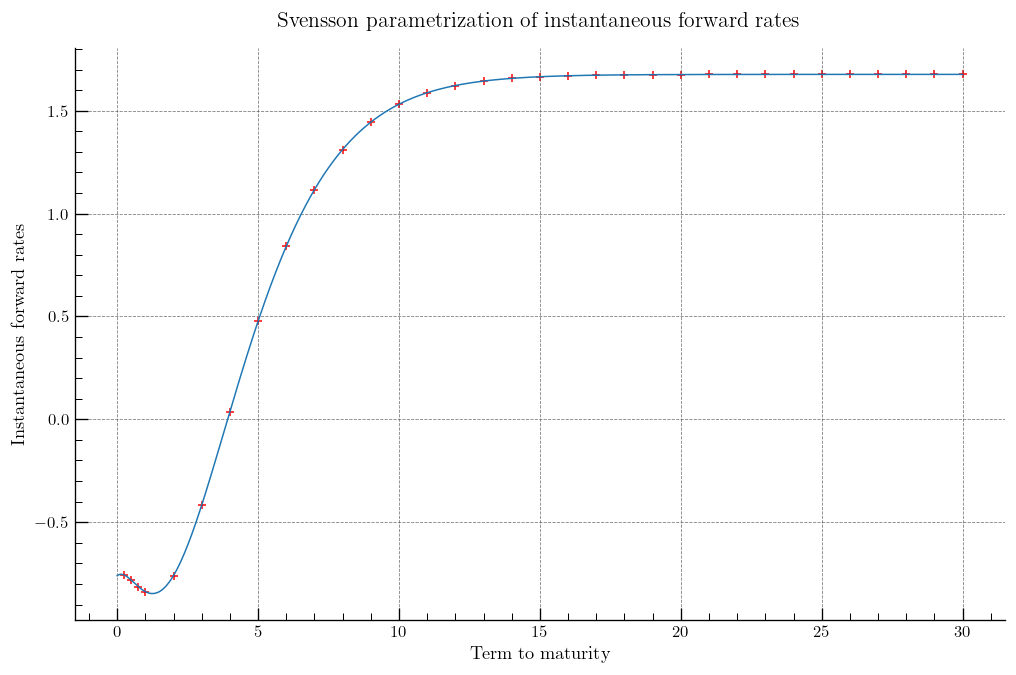

In [7]:
yc.plot.scatter(x='T', y='IFR', marker='+', color='red');
svensson_curve.plot_forward()

The parameters corresponding to this curve can also be retrieved from the website and are:

We can also calibrate the parameters ourselves. Let's consider a mean-square error minimization

In [8]:
svensson_curve.calibrate(yc['T'].values, yc.IFR.values)

Calibrating: iter = 55

/home/abenmoussa/Workspace/python/research/research/fixedincome/curves/parametrization/svensson.py:22: RuntimeWarning: overflow encountered in exp
  ifr += self.b3 * tt2 * np.exp(-tt2)
/home/abenmoussa/Workspace/python/research/research/fixedincome/curves/parametrization/parametrization.py:48: RuntimeWarning: overflow encountered in power
  return np.power(rates - estimates, 2).sum()
/home/abenmoussa/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Calibrating: iter = 56
Optimal parameters found after 56 iterations


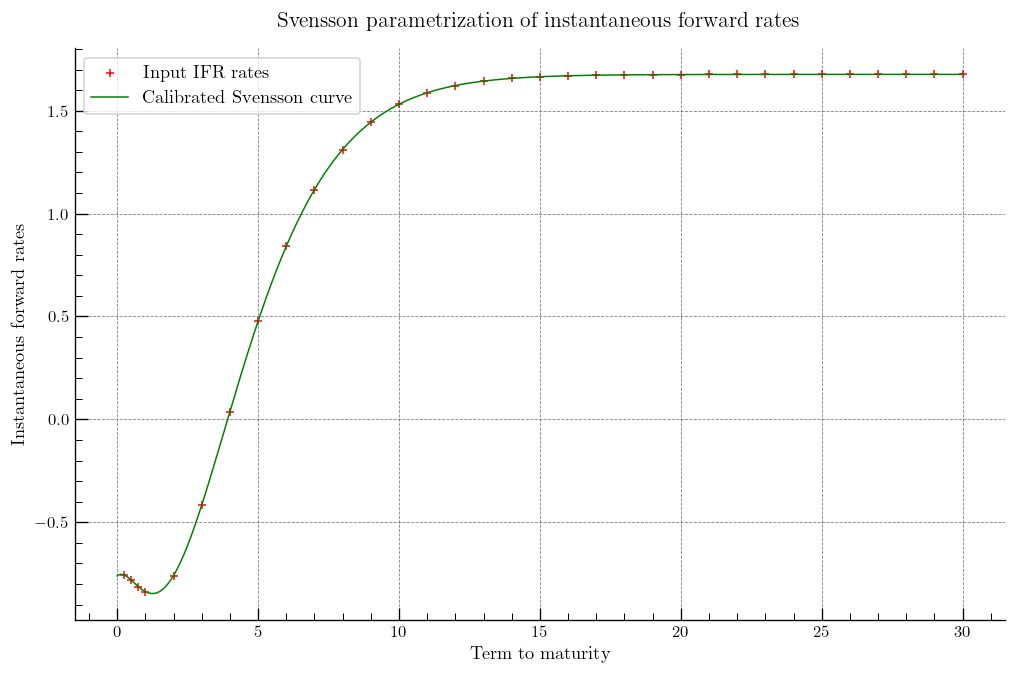

In [9]:
yc.plot.scatter(x='T', y='IFR', marker='+', color='red', label='Input IFR rates');
svensson_curve.plot_forward(color='green', label='Calibrated Svensson curve')
plt.legend();

To compute the bond prices using the Hull-White model we will approximate the integral using a left point method.

In [10]:
def zc_from_hull_white(T, l, sigma, nb_steps=365*30, nb_paths=100_000):
    
    h = T / nb_steps
    r0 = svensson_curve.instantaneous_forward_curve(0)  /100  
    r = np.zeros((nb_steps+1, nb_paths))
    
    r[0, :] = svensson_curve.instantaneous_forward_curve(0)/100
    for s in range(1, nb_steps+1):
        t = s * h
        df = svensson_curve.ifr_derivative(t)/100
        f = svensson_curve.instantaneous_forward_curve(t)/100
        Z = np.random.normal(0, 1, nb_paths)
        theta = df / l + f +  0.5*np.power(sigma / l, 2) * (1- np.exp(-2*l*t))
        r[s,:] =  r[s-1,:] + (l * (theta  - r[s-1, :]) * h + sigma * np.sqrt(h) * Z)

    r[1:] = r[:-1] * h
    r[0] = 0
    r = r.cumsum(axis=0)
    r = np.exp(-r).mean(axis=1)
    return r
    
    

In [11]:
T = 30
sigma = .02
l = 0.5
nb_steps = 30_000
nb_paths = 10_000

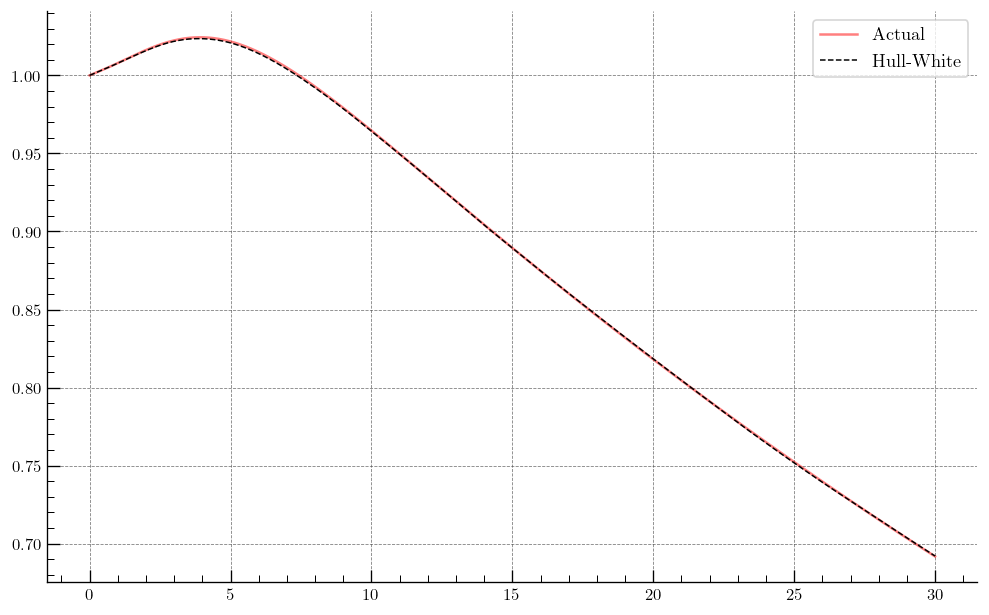

In [12]:
zchw = zc_from_hull_white(T, l, sigma, nb_steps=nb_steps, nb_paths=nb_paths)

t = np.linspace(0, T, nb_steps+1)
zccy = svensson_curve.discount_curve(t)

plt.plot(t, zccy, label='Actual', lw=1.5, color='red', alpha=.5)
plt.plot(t, zchw, label='Hull-White', color='black', ls='--')
plt.legend();

In [13]:
svensson_curve


        Svensson curve parametrization:
        beta_0 = 1.6767447675673344
        beta_1 = -2.438042732135203
        beta_2 = -14.502129821141532
        beta_3 = 10.30221351435607
        tau_1 = 1.626194930788525
        tau_2 = 1.3675026030538628
        